## Transfer Learning mobile V3 using Keras

Download link provided soon

In [ ]:
# # Make the directory if it doesn't exist
# !mkdir -p /content/drive/MyDrive/CNN/

# Download the dataset from Kaggle
!kaggle datasets download -d noulam/tomato -p /content/drive/MyDrive/CNN/

# Unzip the dataset (if necessary)
!unzip /content/drive/MyDrive/CNN/tomato.zip -d /content/drive/MyDrive/CNN/


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CNN/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac022a2b-764c-4507-8dd9-4470b75763e4___RS_HL 9937.JPG  
  inflating: /content/drive/MyDrive/CNN/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac249839-fe21-45cd-9e09-f0023fa7ee3a___GH_HL Leaf 273.JPG  
  inflating: /content/drive/MyDrive/CNN/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdbf632-8d26-472d-874f-6d7df5cd0432___RS_HL 9897.JPG  
  inflating: /content/drive/MyDrive/CNN/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdf2283-0e7c-4ccd-8817-1019e3a8ed20___RS_HL 9943.JPG  
  inflating: /content/drive/MyDrive/CNN/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acf28842-7821-4f31-ab73-27

In [ ]:
!rm -rf '/content/drive/MyDrive/CNN/new plant diseases dataset(augmented)'
!rm -rf '/content/drive/MyDrive/CNN/tomato.zip'

In [ ]:
!nvidia-smi

Wed Oct 23 01:24:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def count_images_in_folders(base_dir):
    # Create a dictionary to store counts
    counts = {}

    # Loop through each folder in the base directory
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)

        # Ensure it's a directory
        if os.path.isdir(folder_path):
            # Count images in the current folder
            image_count = len([file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[folder] = image_count

    return counts

# Define the paths to your train and test directories
train_dir = "/content/drive/MyDrive/CNN/New Plant Diseases Dataset(Augmented)/train"
val_dir = "/content/drive/MyDrive/CNN/New Plant Diseases Dataset(Augmented)/valid"

# Count images in train and test directories
train_counts = count_images_in_folders(train_dir)
val_counts = count_images_in_folders(val_dir)

# Print the results
print("Image counts in train directory:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nImage counts in val_dir directory:")
for class_name, count in val_counts.items():
    print(f"{class_name}: {count} images")

Image counts in train directory:
Tomato___Bacterial_spot: 1702 images
Tomato___Early_blight: 1920 images
Tomato___Late_blight: 1851 images
Tomato___Leaf_Mold: 1882 images
Tomato___Septoria_leaf_spot: 1745 images
Tomato___Spider_mites Two-spotted_spider_mite: 1741 images
Tomato___Target_Spot: 1827 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 images
Tomato___Tomato_mosaic_virus: 1790 images
Tomato___healthy: 1926 images

Image counts in val_dir directory:
Tomato___Bacterial_spot: 425 images
Tomato___Early_blight: 480 images
Tomato___Late_blight: 463 images
Tomato___Leaf_Mold: 470 images
Tomato___Septoria_leaf_spot: 436 images
Tomato___Spider_mites Two-spotted_spider_mite: 435 images
Tomato___Target_Spot: 457 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 490 images
Tomato___Tomato_mosaic_virus: 448 images
Tomato___healthy: 481 images


In [ ]:
# Import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt  # Uncomment if you plan to use matplotlib for plotting


In [ ]:
# Define a function to randomly select images and predict their classes
def predict_random_images(model, data_generator, num_images=9):
    # Get class indices
    class_indices = data_generator.class_indices
    class_names = list(class_indices.keys())

    # Get the total number of images
    total_images = len(data_generator.filenames)

    # Randomly select indices
    random_indices = random.sample(range(total_images), num_images)

    # Create a figure with specified size
    plt.figure(figsize=(15, 10))  # Adjust size as needed

    # Loop through each randomly selected index
    for i, idx in enumerate(random_indices):
        # Get the actual class from the generator
        actual_class = class_names[data_generator.classes[idx]]

        # Load the corresponding image and preprocess it
        img_path = os.path.join(data_generator.directory, data_generator.filenames[idx])  # Full path
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_class = class_names[predicted_class_idx]
        confidence = np.max(predictions)

        # Create a subplot for each image
        plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, position i + 1
        plt.imshow(img)
        plt.axis('off')

        # Annotate the image with smaller font size
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}", fontsize=10)

    # Show the plot
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()

    # Return actual and predicted classes along with their confidences
    return actual_classes, predicted_classes, confidences

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/CNN/New Plant Diseases Dataset(Augmented)/train'
valid_path = '/content/drive/MyDrive/CNN/New Plant Diseases Dataset(Augmented)/valid'


In [ ]:
# Load vgg16 model with ImageNet weights, excluding the top layers
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model layers (optional, you can unfreeze some layers for fine-tuning if needed)
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/CNN/New Plant Diseases Dataset(Augmented)/train/*')

In [ ]:
len(folders)

10

In [ ]:
# Add custom layers on top of vgg16
x = Flatten()(vgg16.output)  # Flatten the output of the vgg16 base model
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),  # Decreased learning rate
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator for training set with brightness, vertical flip, and channel shift intensity added
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.5, 1.5],  # Added brightness shift intensity (0.5 to 1.5)
)

# Image Data Generator for test/validation set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [ ]:
import tensorflow as tf

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
steps_per_epoch = len(training_set) // training_set.batch_size
validation_steps = len(test_set) // test_set.batch_size

print(steps_per_epoch)
print(validation_steps)

17
4


In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(training_set) // training_set.batch_size
validation_steps = len(test_set) // test_set.batch_size

# Fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping],  # Added early_stopping to callbacks list
    verbose=1  # Corrected the syntax here
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 774ms/step - accuracy: 0.1935 - loss: 2.9031 - val_accuracy: 0.3203 - val_loss: 1.9297
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 568ms/step - accuracy: 0.3984 - loss: 1.9109 - val_accuracy: 0.5312 - val_loss: 1.4188
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - accuracy: 0.5475 - loss: 1.3708 - val_accuracy: 0.6484 - val_loss: 1.1572
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 704ms/step - accuracy: 0.5993 - loss: 1.2589 - val_accuracy: 0.6562 - val_loss: 0.9721
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 683ms/step - accuracy: 0.6489 - loss: 1.0690 - val_accuracy: 0.7344 - val_loss: 0.8938
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 634ms/step - accuracy: 0.6233 - loss: 1.0511 - val_accuracy: 0.6094 - val_loss: 1.1158
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - accuracy: 0.6419 - loss: 1.0568 - val_accuracy: 0.7344 - val_loss: 0.7841
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 634ms/step - accuracy: 0.6641 - loss: 0.9403 - val_accuracy: 0.6875

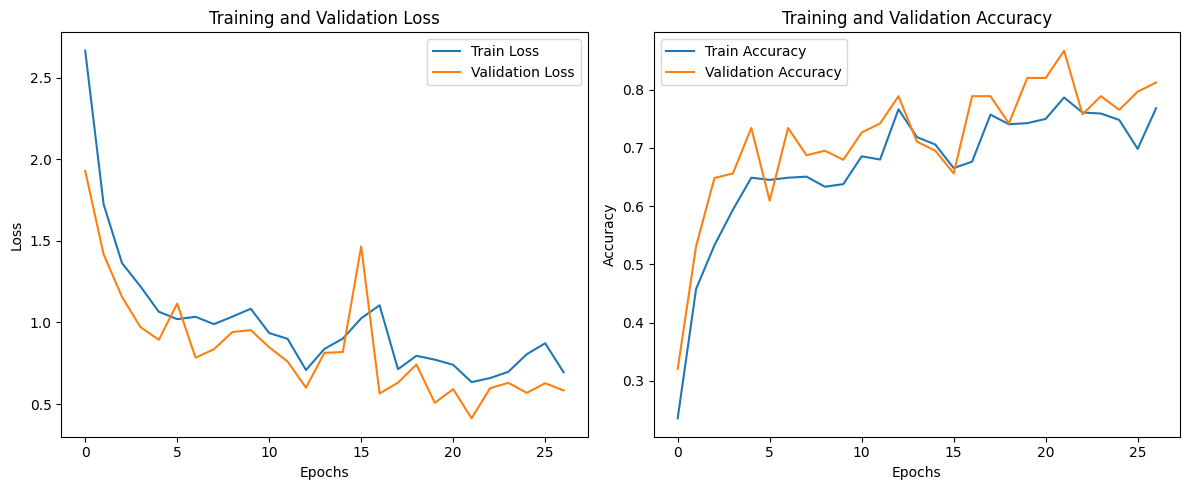

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot the loss
ax[0].plot(r.history['loss'], label='Train Loss')
ax[0].plot(r.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the accuracy
ax[1].plot(r.history['accuracy'], label='Train Accuracy')
ax[1].plot(r.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model

# model.save('model_vgg16.h5')
model.save('/content/drive/MyDrive/CNN/models/model_vgg16.h5')

In [ ]:
from keras.models import load_model

model=load_model('/content/drive/MyDrive/CNN/models/model_vgg16.h5')

In [ ]:
# Predictions
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype("int32")

# True classes
y_true = test_set.classes

144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step


<Figure size 1000x800 with 0 Axes>

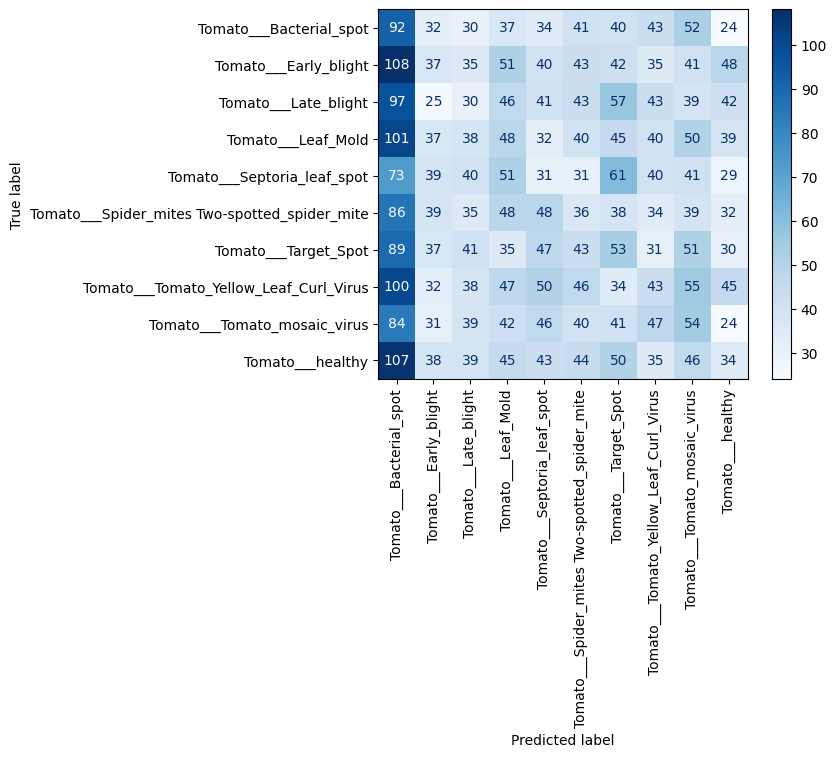

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
class_names = list(training_set.class_indices.keys())  # Get class names from the training set

# Set the figure size to make labels more visible
plt.figure(figsize=(10, 8))  # You can adjust these numbers to fit your needs

# Create and plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot(cmap='Blues', xticks_rotation='vertical')  # Add 'xticks_rotation' for better readability of labels

# Show the plot
plt.show()


In [ ]:
# Classification report
import seaborn as sns
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.10      0.22      0.14       425
                        Tomato___Early_blight       0.11      0.08      0.09       480
                         Tomato___Late_blight       0.08      0.06      0.07       463
                           Tomato___Leaf_Mold       0.11      0.10      0.10       470
                  Tomato___Septoria_leaf_spot       0.08      0.07      0.07       436
Tomato___Spider_mites Two-spotted_spider_mite       0.09      0.08      0.09       435
                         Tomato___Target_Spot       0.11      0.12      0.12       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.11      0.09      0.10       490
                 Tomato___Tomato_mosaic_virus       0.12      0.12      0.12       448
                             Tomato___healthy       0.10      0.07      0.08       481

                                     accu

In [ ]:
# Evaluate the model
eval_result = model.evaluate(test_set)
print('\nLoss rate on evaluation data:', eval_result[0])
print('\nAccuracy rate on evaluation data:', eval_result[1])

144/144 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.8118 - loss: 0.5609

Loss rate on evaluation data: 0.5467687845230103

Accuracy rate on evaluation data: 0.8161395788192749


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


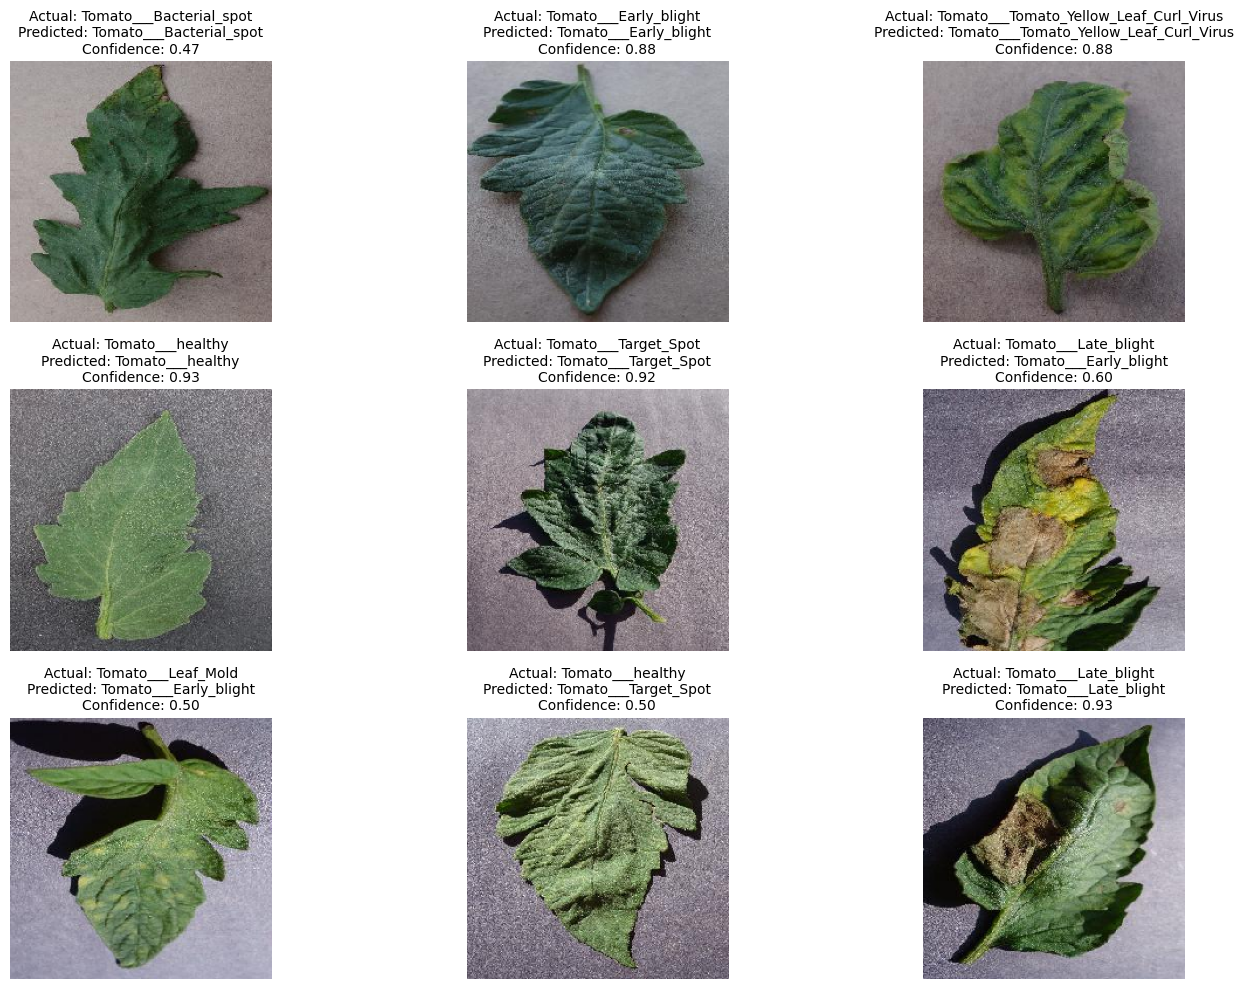

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Call the function to predict and plot random images
actual_classes, predicted_classes, confidences = predict_random_images(model, test_set, num_images=9)

## **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19


In [ ]:
# Load vgg16 model with ImageNet weights, excluding the top layers
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the base model layers (optional, you can unfreeze some layers for fine-tuning if needed)
for layer in vgg19.layers:
    layer.trainable = False


# Add custom layers on top of vgg19
x = Flatten()(vgg19.output)  # Flatten the output of the vgg19 base model
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# view the structure of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,275,274 (77.34 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),  # Decreased learning rate
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator for training set with brightness, vertical flip, and channel shift intensity added
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    brightness_range=[0.5, 1.5],  # Added brightness shift intensity (0.5 to 1.5)
)

In [ ]:
# Image Data Generator for test/validation set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [ ]:
import tensorflow as tf

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Calculate steps per epoch
steps_per_epoch = len(training_set) // training_set.batch_size
validation_steps = len(test_set) // test_set.batch_size

# Fit the model
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping],  # Added early_stopping to callbacks list
    verbose=1  # Corrected the syntax here
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1551 - loss: 3.6942 - val_accuracy: 0.2266 - val_loss: 2.1012
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - accuracy: 0.2931 - loss: 2.0770 - val_accuracy: 0.4688 - val_loss: 1.6078
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 903ms/step - accuracy: 0.4235 - loss: 1.8144 - val_accuracy: 0.5547 - val_loss: 1.3501
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.5426 - loss: 1.3647 - val_accuracy: 0.5391 - val_loss: 1.2521
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5886 - loss: 1.2029 - val_accuracy: 0.5781 - val_loss: 1.0565
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accuracy: 0.5784 - loss: 1.2285 - val_accuracy: 0.5234 - val_loss: 1.3614
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 666ms/step - accuracy: 0.6326 - loss: 1.1509 - val_accuracy: 0.6797 - val_loss: 1.0466
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 684ms/step - accuracy: 0.5970 - loss: 1.1965 - val_accuracy: 0.6719 - va

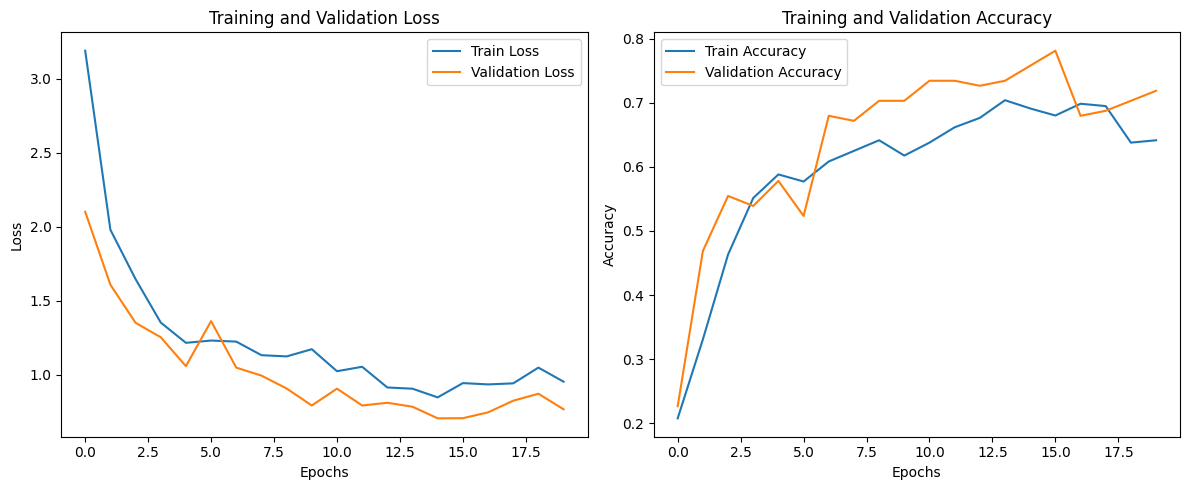

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot the loss
ax[0].plot(r.history['loss'], label='Train Loss')
ax[0].plot(r.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the accuracy
ax[1].plot(r.history['accuracy'], label='Train Accuracy')
ax[1].plot(r.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model

# model.save('model_vgg16.h5')
model.save('/content/drive/MyDrive/CNN/models/model_vgg19.h5')

In [ ]:
model=load_model('/content/drive/MyDrive/CNN/models/model_vgg19.h5')

In [17]:
# Predictions
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype("int32")

# True classes
y_true = test_set.classes

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 31/144 ━━━━━━━━━━━━━━━━━━━━ 50:35 27s/step

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

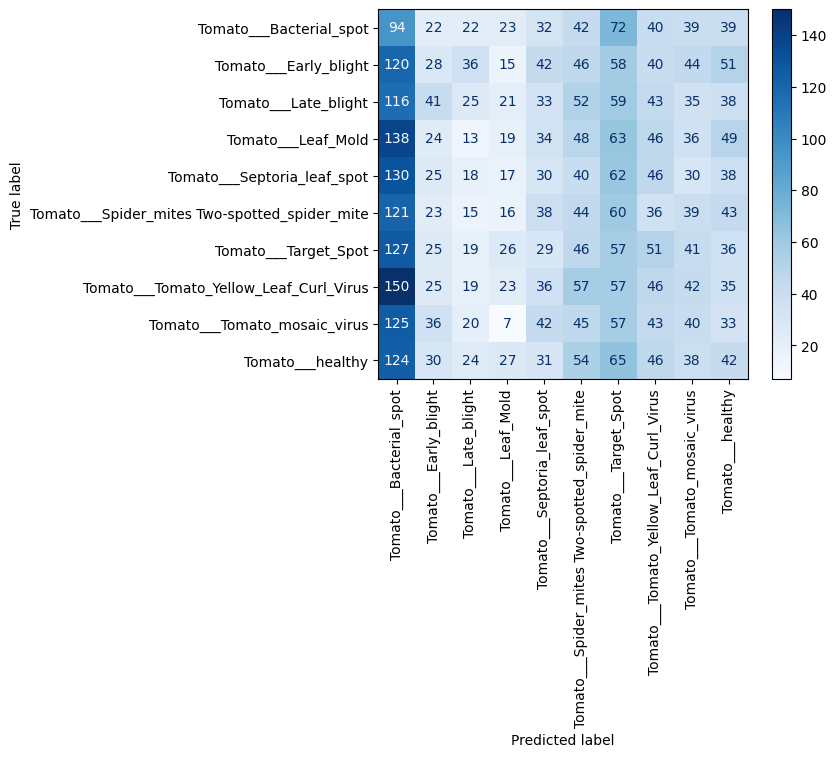

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
class_names = list(training_set.class_indices.keys())  # Get class names from the training set

# Set the figure size to make labels more visible
plt.figure(figsize=(10, 8))  # You can adjust these numbers to fit your needs

# Create and plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot(cmap='Blues', xticks_rotation='vertical')  # Add 'xticks_rotation' for better readability of labels

# Show the plot
plt.show()

In [ ]:
# Classification report
import seaborn as sns
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.08      0.22      0.11       425
                        Tomato___Early_blight       0.10      0.06      0.07       480
                         Tomato___Late_blight       0.12      0.05      0.07       463
                           Tomato___Leaf_Mold       0.10      0.04      0.06       470
                  Tomato___Septoria_leaf_spot       0.09      0.07      0.08       436
Tomato___Spider_mites Two-spotted_spider_mite       0.09      0.10      0.10       435
                         Tomato___Target_Spot       0.09      0.12      0.11       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.11      0.09      0.10       490
                 Tomato___Tomato_mosaic_virus       0.10      0.09      0.10       448
                             Tomato___healthy       0.10      0.09      0.09       481

                                     accu

In [ ]:
# Evaluate the model
eval_result = model.evaluate(test_set)
print('\nLoss rate on evaluation data:', eval_result[0])
print('\nAccuracy rate on evaluation data:', eval_result[1])

In [ ]:
# Call the function to predict and plot random images
actual_classes, predicted_classes, confidences = predict_random_images(model, test_set, num_images=9)